In [ ]:
'''
USE `orders`;

SET @R1 := 365; -- покупали более чем год назад
SET @R3 := 100; 
SET @R4 := 60;
SET @R5 := 30; -- менее чем месяц назад

-- frequency
SET @F1 := 1;
SET @F2 := 2;
SET @F3 := 10;
SET @F4 := 20;
SET @F5 := 50; 

-- monetary
SET @M1 := 0;
SET @M2 := 500;
SET @M3 := 1000;
SET @M4 := 10000;
SET @M5 := 50000;


-- SET @last_date := (SELECT MAX(`o_date`) FROM `orders_20190822`);
SET @last_date := (SELECT MAX(`o_date`) FROM `orders_20190822` WHERE `o_date` < '2017-01-01');
SET @overall_sum := (SELECT SUM(`price`) FROM `orders_20190822` WHERE `price` > 0 and `o_date` < @last_date);

DROP TABLE IF EXISTS `rfm_table_20170101`;
CREATE TABLE `rfm_table_20170101` AS 
WITH
	  `R` as (SELECT  `user_id`, 
	                MAX(`o_date`) `maxdate`, 
	                DATEDIFF(@last_date, MAX(`o_date`)) `days` 
	        FROM `orders_20190822` 
	        WHERE `price` > 0  and `o_date` < @last_date
	        GROUP BY `user_id`),

	  `F` AS (SELECT `user_id`, 
	   			     COUNT(DISTINCT `id_o`) `cnt` 
	   		  FROM `orders_20190822` 	
	  		  WHERE `price` > 0 and `o_date` < @last_date
	  		  GROUP BY `user_id`),
	  
	  `M` AS (SELECT `user_id`, 
	  			     SUM(`price`) `sum_price` 
	  	      FROM `orders_20190822` 
	  	      WHERE `price` > 0  and `o_date` < @last_date
	  	      GROUP BY `user_id`),
	  
	  `RFM` as (SELECT `R`.`user_id`, 
	  				  `R`.`days` as `R`, 
	  				  `F`.`cnt` as `F`, 
	  				  `M`.`sum_price` as `M`,
	  				  CASE  
	  				  		WHEN `R`.`days` > @R1 THEN 1 -- более чем год назад
	  				  	    WHEN `R`.`days` BETWEEN @R3 AND @R1 THEN 2 -- последняя покупка 100-365 дней назад
	  				  	    WHEN `R`.`days` BETWEEN @R4 and @R3 THEN 3 -- 60-100 дней назад
	  				  	    WHEN  `R`.`days` BETWEEN @R5 AND @R4 THEN 4 -- 30-60 дней назад
	  				  		WHEN `R`.`days` < @R5 THEN 5 -- менее чем 30 дней назад
	      					ELSE 0
	      					END as 
	      						`R1`,

	      			  CASE  WHEN `F`.`cnt` = @F1 THEN 1 -- 1 покупкa
	            			WHEN  `F`.`cnt` BETWEEN @F2 AND @F3 THEN 2 -- 2-10 покупок
	            			WHEN `F`.`cnt` BETWEEN @F3 AND @F4 THEN 3 -- 10-20 покупок
	            			WHEN `F`.`cnt` BETWEEN @F4 AND @F5 THEN 4 -- 20-50 покупок
	      					WHEN `F`.`cnt` > @F5 THEN 5 -- больше 50 покупок
	      					ELSE 0 
	      			  END as `F1`, 

	      			  CASE WHEN `M`.`sum_price` BETWEEN @M1 AND @M2 THEN 1 -- 0-500р.
	      			  	   WHEN `M`.`sum_price` BETWEEN @M2 AND @M3 THEN 2 -- 500-1т.р.
	      			  	   WHEN `M`.`sum_price` BETWEEN @M3 AND @M4 THEN 3 -- 1-10т.р.
	      			  	   WHEN `M`.`sum_price` BETWEEN @M4 AND @M5 THEN 4 -- 10-50т.р.
	      			  	   WHEN `M`.`sum_price` > @M5 THEN 5 -- больше 50т.р.
	      			  	   ELSE 0
	      			  END
	      			   as `M1`

	      
	    	   FROM `R` 
	    	   INNER JOIN `F` 
	    	   ON `R`.`user_id` = `F`.`user_id`
	    	   INNER JOIN `M`
	    	   ON `F`.`user_id` = `M`.`user_id`),

	  `USERGROUPS` AS (SELECT `RFM`.`user_id`,
	  						  `RFM`.`R`,
	      					  `RFM`.`F`,
	      					  CONCAT('R', `RFM`.`R1`,'-', 'F', `RFM`.`F1`, '-', 'M', `RFM`.`M1`) `RFM`,
	      					  CASE  
	            			  WHEN  CONCAT(`RFM`.`R1`,`RFM`.`F1`, `RFM`.`M1`) 
	            			  -- when R1 in (3, 4, 5) and M1 in (4, 5) and F1 in (4, 5) then 'VIP'
	            			  	IN ("555", "455", "355", "345", "354", "445", "325", "335", "554", "545") 
	            			  	THEN 'VIP' 
	      
	            			  WHEN CONCAT(`RFM`.`R1`,`RFM`.`F1`, `RFM`.`M1`)
	            			  -- when R1 in (4, 5) and F1 in (1, 2) and M1 in (1, 2, 3, 4, 5) then 'NEW'
	            			  	IN ("411", "412", "413", "414", "415", "421", "422", "423", "424", "425", "511", "512", "514", "515", "521", "524", "524", "525") /* NEW: R(4, 5)-F(1, 2)-M(any)  */
	            			  	THEN 'NEW'

	            			  WHEN CONCAT(`RFM`.`R1`,`RFM`.`F1`, `RFM`.`M1`)
	            			  -- when R1 in (1, 2) and F1 in (4, 5) and M1 in (4, 5)
	            			  	IN("144", "145", "154", "155", "244", "224", "314", "245", "223", "254", "255", "241", "242", "313", "243", "251", "252", "253", "225", "231", "232", "233", "234", "235")
	            			  	THEN 'CHURNED'

	            			  WHEN  CONCAT(`RFM`.`R1`,`RFM`.`F1`, `RFM`.`M1`) 
	            			  -- when R1 in (3, 4, 5) and F1 in (4, 5) and M1 in (3, 4, 5) then 'REGULAR'
	            			  	IN ("544", "543", "533", "534", "535", "454", "434", "435", "531", "443", "441", "442", "444", "333", "341", "342", "343", "344", "321", "322", "323", "324", "334") 
	            			  	THEN 'REGULAR' 

	            		      WHEN CONCAT(`RFM`.`R1`, `RFM`.`F1`, `RFM`.`M1`)
	            		      	IN ("221", "222", "115", "433", "311", "312", "315",  "124", "125", "523", "513", "522")
	            		      	THEN "HOPEFOOL"

	            			  WHEN CONCAT(`RFM`.`R1`,`RFM`.`F1`, `RFM`.`M1`) 
	            			    IN ("111", "112", "113", "114", "121", "122", "123", "134", "215", "214", "213", "212", "211") 
	            			  	THEN 'LOST'

	            			  ELSE 'undefined_group' 

	      				      END as `G`
	    			   FROM `RFM`)

-- consolidated table
  SELECT `u`.`G` `group`,
	  		 `u`.`user_id` `user_id`, 
	  		 `u`.`RFM` `index`,
	  		 -- `t`.`count_by_rfm` `count_by_rfm`,
	  		 `t1`.`count_by_group` `count_by_group`,
	  		 `R`.`days` `days`, 
	  		 `F`.`cnt` `orders`,
	  		 `m`.`sum_price` `sum`, 
	  		 ROUND(`m`.`sum_price` / @overall_sum, 2) `% of turnover`

	  FROM `USERGROUPS` `u` 
	  LEFT JOIN `M` `m` ON `u`.`user_id` = `m`.`user_id` 
	  LEFT JOIN `R` ON `R`.`user_id` = `m`.`user_id`
	  LEFT JOIN `F` ON `F`.`user_id` = `R`.`user_id`
	  -- LEFT JOIN (SELECT `u`.`user_id`, `u`.`RFM` `index`, COUNT(*) `count_by_rfm`
	 				-- FROM `USERGROUPS` `u`
	 				-- GROUP BY `index`) as t 
	  		-- ON `t`.`user_id` = `F`.`user_id`
	  LEFT JOIN (SELECT `u`.`user_id`, `u`.`G` `group`, COUNT(*) `count_by_group` 
	  				FROM `USERGROUPS` `u`
	  				GROUP BY `group`) as `t1`
	  		ON `F`.`user_id` = `t1`.`user_id`

	  		;
'''

In [1]:
import mariadb
import sys 
import os
from dotenv import load_dotenv
import pandas as pd
load_dotenv()
passwd = os.getenv('PASSWD')
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

In [2]:
def create_rfm_table(date: str):
    try: 
        conn = mariadb.connect(user='root',
                              password=passwd,
                              host='localhost',
                              port=3306,
                              database='orders')
    except mariadb.Error as e:
        print(f'error')
        sys.exit()  
    
    
    cur = conn.cursor()
    rfm_table = pd.read_sql_query(f''' 
                    SELECT * FROM `rfm_table_{(date).replace('-', '')}`''', conn)
    return rfm_table

In [3]:
rfmtable01 = create_rfm_table('2017-01-01')
rfmtable02 = create_rfm_table('2017-02-01')
rfmtable03 = create_rfm_table('2017-03-01')

In [44]:
rfm_table = pd.concat([rfmtable01, rfmtable02, rfmtable03], axis=0, sort=False)
vip = rfm_table.loc[((rfm_table['group'] == 'VIP'))]
uf = rfm_table.loc[(rfm_table['group'] == 'undefined_group')]
tiny = pd.concat([vip, uf], axis=0, sort=False)

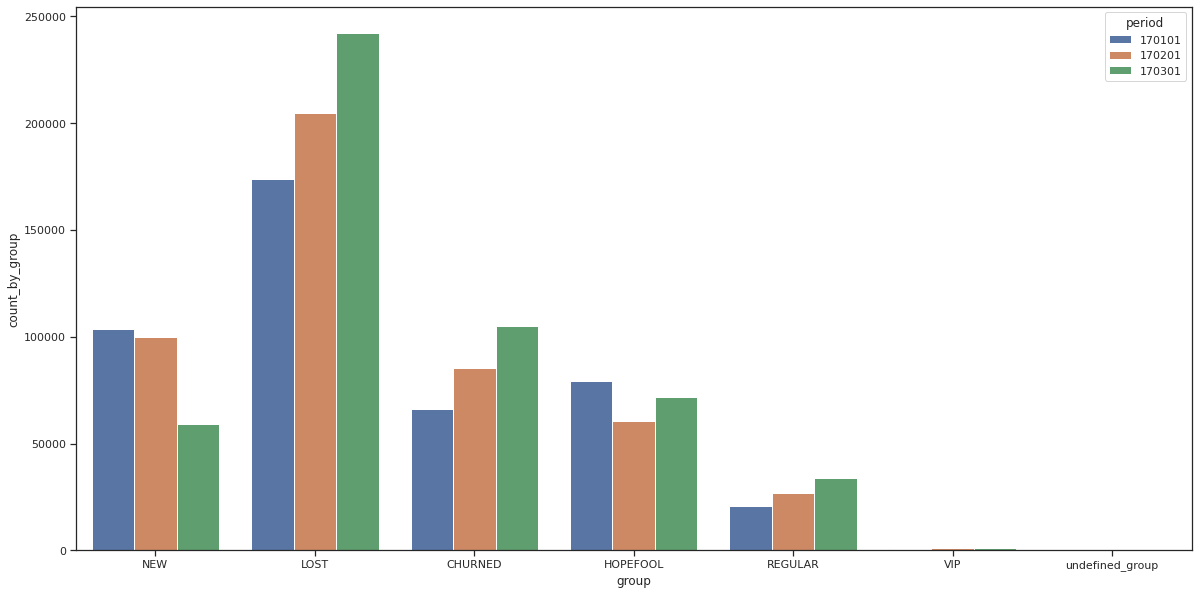

In [47]:
plt.figure(figsize=(20, 10))
sns.barplot(x="group", y="count_by_group", hue="period", data=rfm_table);

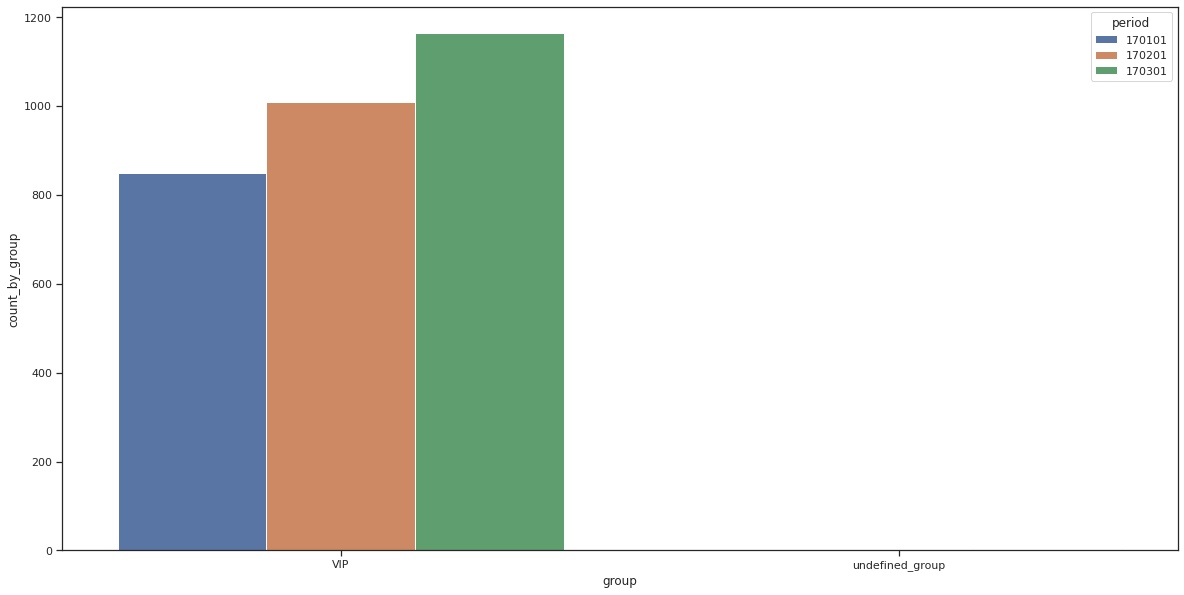

In [48]:
plt.figure(figsize=(20, 10))
sns.barplot(x="group", y="count_by_group", hue="period", data=tiny);